1. Setup & Imports

In [3]:
# UFC AI Project - Training & Hypothetical Fight Prediction
# Running in Google Colab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import xgboost as xgb

plt.style.use('seaborn-v0_8-whitegrid')

2. Load & Inspect Data

In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("ufc_stats.csv")

Saving ufc_stats.csv to ufc_stats.csv


3. Data Cleaning

In [5]:
# Clean fighter names
df['fighter'] = df['fighter'].str.strip().str.lower().str.replace('"', '', regex=False)
df['winner'] = df['winner'].str.strip().str.lower().str.replace('"', '', regex=False)

# Keep only completed fights
df = df[df['winner'].notnull() & df['winner'].isin(['w', 'l'])]
df.head()

,fighter,knockdowns,significant_strikes_landed,significant_strikes_attempted,significant_strikes_rate,total_strikes_landed,total_strikes_attempted,takedown_successful,takedown_attempted,takedown_rate,...,last_round,time,scheduled_rounds,winner,weight_class,event,fight_date,location,attendance,id
0,johnny walker,0,9,22,0.40,10,25,0,2,0.0,...,2,2:37,5 Rnd (5-5-5-5-5),w,Light Heavyweight Bout,UFC Fight Night: Walker vs. Zhang,2025-08-23,"Shanghai, Hebei, China",NaN,8277
1,zhang mingyang,0,12,30,0.40,20,42,0,0,0.0,...,2,2:37,5 Rnd (5-5-5-5-5),l,Light Heavyweight Bout,UFC Fight Night: Walker vs. Zhang,2025-08-23,"Shanghai, Hebei, China",NaN,8277
2,johnny walker,1,41,45,0.91,41,45,0,0,0.0,...,2,2:37,5 Rnd (5-5-5-5-5),w,Light Heavyweight Bout,UFC Fight Night: Walker vs. Zhang,2025-08-23,"Shanghai, Hebei, China",NaN,8277
3,zhang mingyang,0,8,17,0.47,8,17,0,0,0.0,...,2,2:37,5 Rnd (5-5-5-5-5),l,Light Heavyweight Bout,UFC Fight Night: Walker vs. Zhang,2025-08-23,"Shanghai, Hebei, China",NaN,8277
4,brian ortega,0,2,28,0.07,2,28,0,0,0.0,...,5,5:00,5 Rnd (5-5-5-5-5),l,Catch Weight Bout,UFC Fight Night: Walker vs. Zhang,2025-08-23,"Shanghai, Hebei, China",NaN,8278


4. Feature Engineering

In [6]:
numeric_cols = [
    'knockdowns', 'significant_strikes_landed', 'significant_strikes_attempted',
    'significant_strikes_rate', 'total_strikes_landed', 'total_strikes_attempted',
    'takedown_successful', 'takedown_attempted', 'takedown_rate',
    'submission_attempt', 'reversals', 'head_landed', 'body_landed',
    'leg_landed', 'distance_landed', 'clinch_landed', 'ground_landed'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['sig_strike_accuracy'] = df['significant_strikes_landed'] / (df['significant_strikes_attempted'] + 1)
df['takedown_accuracy'] = df['takedown_successful'] / (df['takedown_attempted'] + 1)

5. Build Fight-Level Dataset

In [25]:
rows = []
for fight_id in df['id'].unique():
    fight_df = df[df['id'] == fight_id]
    if len(fight_df) != 2:
        continue
    f1, f2 = fight_df.iloc[0], fight_df.iloc[1]
    target = 1 if f1['winner'] == 'l' else 0
    row = {f"f1_{c}": f1[c] for c in numeric_cols}
    row.update({f"f2_{c}": f2[c] for c in numeric_cols})
    row['target'] = target
    rows.append(row)

model_df = pd.DataFrame(rows)
model_df['target'].value_counts(normalize=True)

,proportion
target,
0,0.679443
1,0.320557


Check class balance

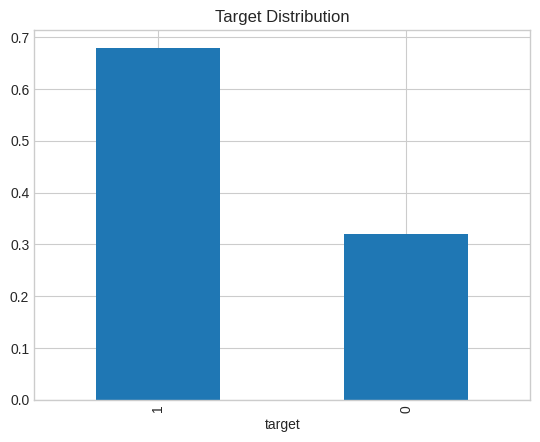

In [8]:
model_df['target'].value_counts(normalize=True).plot(kind='bar', title='Target Distribution')
plt.show()

6. Model Training

Accuracy: 0.9652173913043478
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       313
           1       0.96      0.93      0.94       147

    accuracy                           0.97       460
   macro avg       0.96      0.96      0.96       460
weighted avg       0.97      0.97      0.97       460



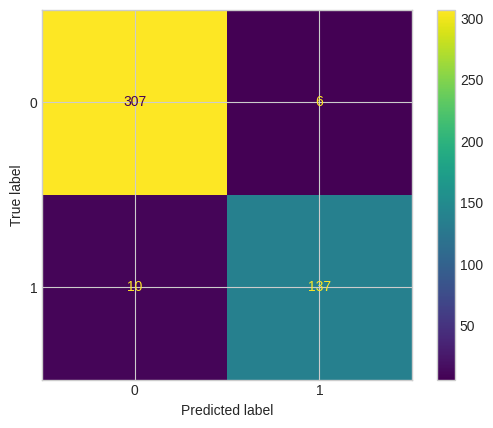

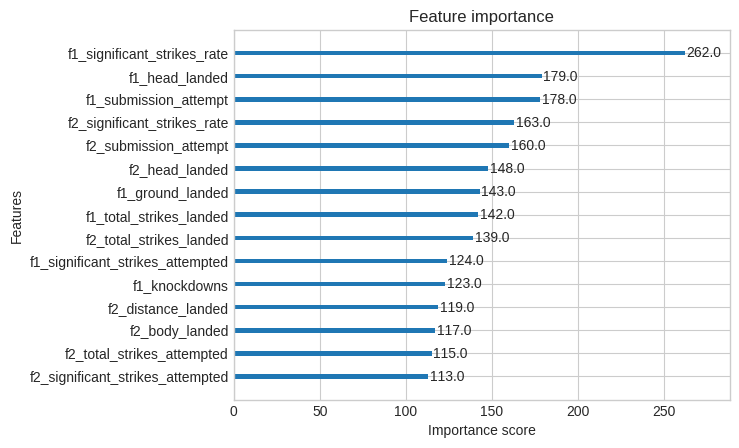

In [26]:
X = model_df.drop(columns='target')
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
xgb.plot_importance(model, max_num_features=15)
plt.show()

7. Aggregate Fighter Stats

In [10]:
fighter_stats = df.groupby('fighter').agg({col: 'mean' for col in numeric_cols}).reset_index()
fighter_stats.head()

,fighter,knockdowns,significant_strikes_landed,significant_strikes_attempted,significant_strikes_rate,total_strikes_landed,total_strikes_attempted,takedown_successful,takedown_attempted,takedown_rate,submission_attempt,reversals,head_landed,body_landed,leg_landed,distance_landed,clinch_landed,ground_landed
0,aalon cruz,0.0,1.000000,7.500000,0.080000,1.000000,7.500000,0.000000,1.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,0.0,0.000000
1,aaron brink,0.0,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,aaron phillips,0.0,7.181818,13.454545,0.529091,38.636364,48.727273,0.272727,0.545455,0.120909,0.181818,0.090909,3.272727,3.454545,0.454545,4.0,2.0,1.181818
3,aaron pico,0.0,13.000000,29.000000,0.440000,13.000000,30.000000,2.000000,3.000000,0.660000,0.000000,0.000000,7.000000,5.000000,1.000000,7.0,3.0,3.000000
4,aaron riley,0.0,15.700000,45.200000,0.346000,29.050000,59.500000,0.400000,1.150000,0.200000,0.050000,0.000000,7.350000,4.600000,3.750000,9.5,5.1,1.100000


8. Hypothetical Fight Predictor

In [29]:
def predict_fight(f1_name, f2_name):
    f1, f2 = f1_name.lower(), f2_name.lower()
    if f1 not in fighter_stats['fighter'].values or f2 not in fighter_stats['fighter'].values:
        raise ValueError("Missing fighter stats.")
    f1_row = fighter_stats[fighter_stats['fighter'] == f1].iloc[0]
    f2_row = fighter_stats[fighter_stats['fighter'] == f2].iloc[0]
    f1_feats = {f"f1_{col}": f1_row[col] for col in numeric_cols}
    f2_feats = {f"f2_{col}": f2_row[col] for col in numeric_cols}
    X_new = pd.DataFrame([{**f1_feats, **f2_feats}])
    pred = model.predict(X_new)[0]
    prob = model.predict_proba(X_new)[0]
    return {
      'winner': f1_name if pred == 1 else f2_name,
      'prob_f1': float(prob[1]),
      'prob_f2': float(prob[0])
  }


print(predict_fight("Islam Makhachev", "Jack Della Maddalena"))
print(predict_fight("Jon Jones", "Tai Tuivasa"))
print(predict_fight("Alexander Volkanovski", "Brian Ortega"))
print(predict_fight("Sean Strickland", "Khamzat Chimaev"))
print(predict_fight("Charles Oliveira", "Dustin Poirier"))

{'winner': 'Islam Makhachev', 'prob_f1': 0.9972000122070312, 'prob_f2': 0.00279998779296875}
{'winner': 'Tai Tuivasa', 'prob_f1': 0.03571212664246559, 'prob_f2': 0.9642878770828247}
{'winner': 'Brian Ortega', 'prob_f1': 0.015290708281099796, 'prob_f2': 0.9847092628479004}
{'winner': 'Sean Strickland', 'prob_f1': 0.9945520758628845, 'prob_f2': 0.0054479241371154785}
{'winner': 'Charles Oliveira', 'prob_f1': 0.9753139615058899, 'prob_f2': 0.024686038494110107}


Feature Importance / Insights

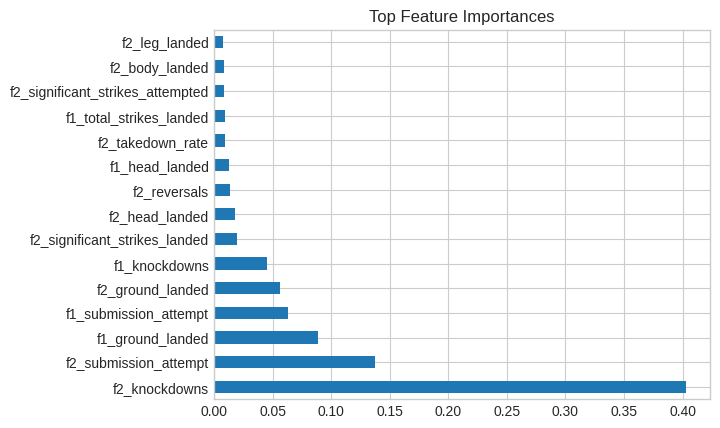

In [30]:
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
fi.head(15).plot(kind='barh', title="Top Feature Importances")
plt.show()

Export model (optional)

In [ ]:
#import joblib
#joblib.dump(model, "xgb_fight_predictor.pkl")